In [18]:
# Import necessary packages
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import pandas as pd
from sklearn.metrics import RocCurveDisplay, classification_report
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import shap
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from scipy.stats import pearsonr

In [125]:
# Import data
Tornadoes = pd.read_csv('/data/keeling/a/mgraber2/Course scripts/ATMS523/Module6/1950-2021_actual_tornadoes.csv')
modes = pd.read_csv('/data/keeling/a/mgraber2/Course scripts/ATMS523/Module6/climatemodes.csv')

(1) Aggregate the tornado data over Illinois into a monthly count of tornadoes

To remain consistent with my research and other research, I will not include F/EF-0 tornado reports in this analysis since these reports do not give much of an indicator to tornado climatologies. 

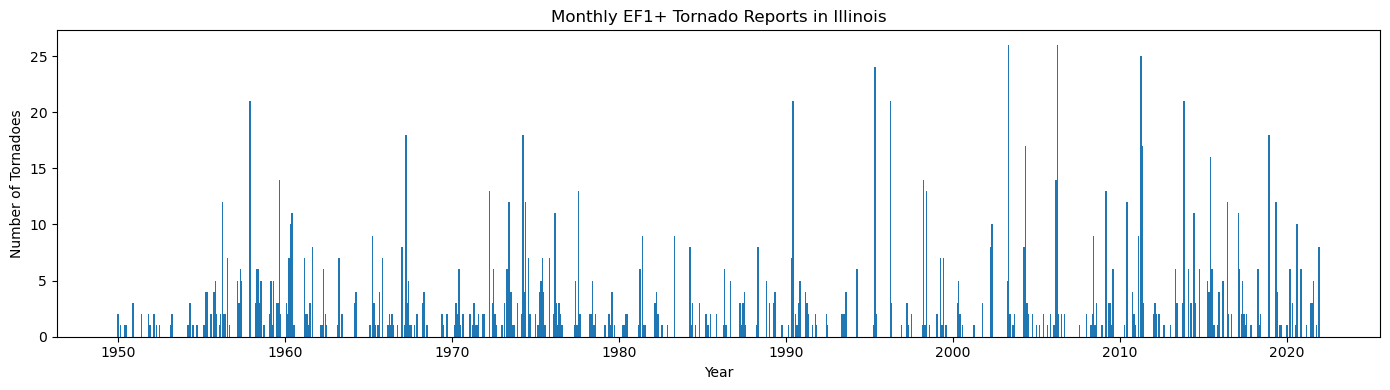

In [126]:
# Only keep columns that are necessary
# Ensure dates are in datetime format
# Only want Illinois and EF/F-1+ tornado reports
# Make and plot a monthly time series
Tornadoes = Tornadoes[['yr', 'date', 'st', 'mag']]

Tornadoes['date'] = pd.to_datetime(Tornadoes['date'])

Tornadoes_IL = Tornadoes[(Tornadoes['st'] == 'IL') & (Tornadoes['mag'] >= 1)].copy()

# Create monthly period column
Tornadoes_IL['year_month'] = Tornadoes_IL['date'].dt.to_period('M')

# Count reports per month
monthly_counts = Tornadoes_IL.groupby('year_month').size()
monthly_counts.index = monthly_counts.index.to_timestamp()

# Plot as bar graph
plt.figure(figsize=(14, 4))
plt.bar(monthly_counts.index, monthly_counts.values, width=30)  # wider bars look better for monthly data
plt.title("Monthly EF1+ Tornado Reports in Illinois")
plt.xlabel("Year")
plt.ylabel("Number of Tornadoes")
plt.tight_layout()
plt.show()

(2) Merge this monthly tornado dataset with the ENSO, PDO, NAO, and AO dataframe created in Module 4 Notebook 1.

In [127]:
# Create full monthly range for 1951–2021
full_range = pd.date_range("1951-01-01", "2021-12-01", freq="MS")

# Reindex monthly_counts to include every month (missing → 0)
monthly_counts = monthly_counts.reindex(full_range, fill_value=0)

# Make sure it is a DataFrame (easier for merging)
monthly_counts.index = pd.to_datetime(monthly_counts.index)
monthly_counts = monthly_counts.to_frame(name="tornado_count")

# Keep 1951–2021 only for modes
modes['Date'] = pd.to_datetime(modes['Date'])
modes = modes.set_index('Date')
modes = modes.loc["1951-01-01":"2021-12-01"]

# merge the climate modes with the monthly tornado counts
merged = modes.join(monthly_counts, how='left')


(3) Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes. Create a scatter plot of the predicted and observed number of tornadoes over these states. Report the correlation coefficient and RMSE of your model.

RMSE: 4.08
cc: 0.07


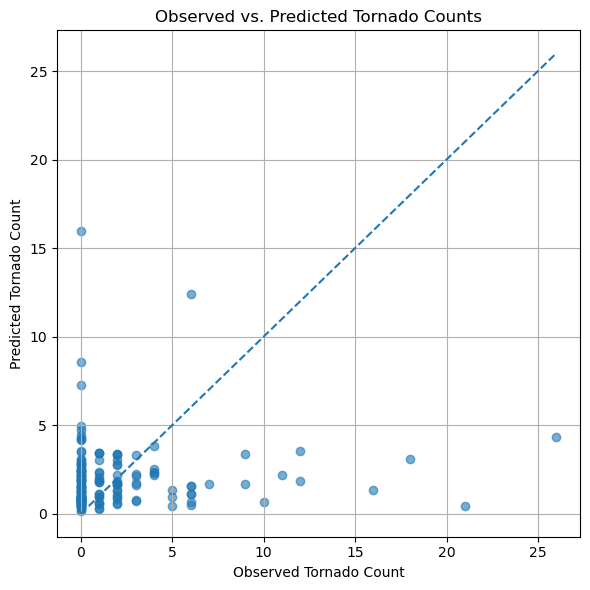

In [128]:
# Identify features and variables
# Use the random forest regressor
X = merged.iloc[:,0:4].values
y = merged.iloc[:,4].values

rf = RandomForestRegressor(
    n_estimators=500,      # number of trees
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calculate cc and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
cc, _ = pearsonr(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"cc: {cc:.2f}")

# Make scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)

# 1:1 reference line
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')

plt.xlabel("Observed Tornado Count")
plt.ylabel("Predicted Tornado Count")
plt.title("Observed vs. Predicted Tornado Counts")
plt.grid(True)
plt.tight_layout()
plt.show()


(4) Create a one-hot encoding for the month of the year. Repeat the scatterplot and compare the RMSE and correlation coefficient values.

RMSE: 3.68
CC: 0.31


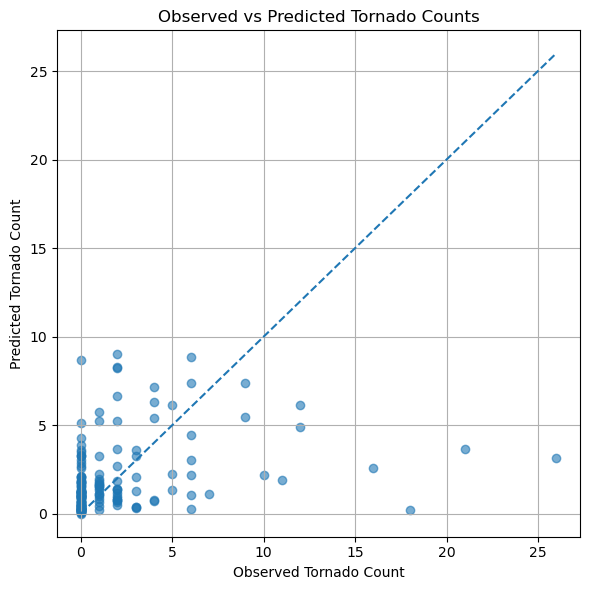

In [129]:
# Create a one-hot encoder
merged['month'] = merged.index.month

numeric_features = ['ENSO', 'PDO', 'NAO', 'AO']
categorical_features = ['month']
target = 'tornado_count'

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

rf_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('rf', RandomForestRegressor(
        n_estimators=500,
        random_state=42
    ))
])

X_model = merged[numeric_features + categorical_features]
y_model = merged[target]

X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(
    X_model, y_model, test_size=0.2, random_state=42
)

rf_model.fit(X_train_model, y_train_model)

y_pred = rf_model.predict(X_test_model)

rmse = np.sqrt(mean_squared_error(y_test_model, y_pred))
r2 = r2_score(y_test_model, y_pred)
cc, _ = pearsonr(y_test_model, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"CC: {cc:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test_model, y_pred, alpha=0.6)

min_val = min(min(y_test_model), min(y_pred))
max_val = max(max(y_test_model), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--')

plt.xlabel("Observed Tornado Count")
plt.ylabel("Predicted Tornado Count")
plt.title("Observed vs Predicted Tornado Counts")
plt.grid(True)
plt.tight_layout()
plt.show()

(5) Perform a feature importance and multipass permutation analysis of your features.

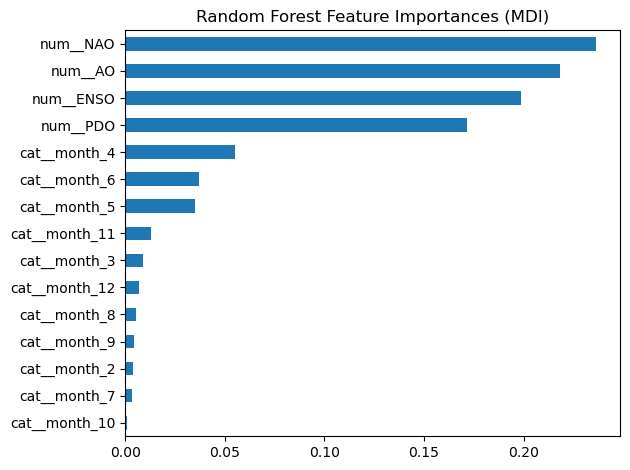

In [130]:
# Perform feature importance
feature_names = rf_model[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf_model[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

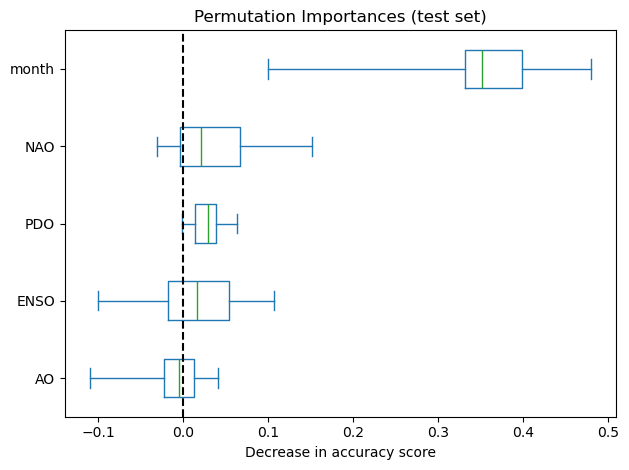

In [131]:
# Perform multipass permutation analysis
result = permutation_importance(
    rf_model, X_test_model, y_test_model, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_model.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

(6) Create a SHAP Summary Plot showing feature importance and feature effects.

In [132]:
merged['month'] = merged.index.month_name()

numeric_features = ['ENSO', 'PDO', 'NAO', 'AO']
categorical_features = ['month']
target = 'tornado_count'

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

In [133]:
rf_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=500, random_state=42))
])

X = merged[numeric_features + categorical_features]
y = merged[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['month']),
                                                 ('num', 'passthrough',
                                                  ['ENSO', 'PDO', 'NAO',
                                                   'AO'])])),
                ('rf',
                 RandomForestRegressor(n_estimators=500, random_state=42))])

In [134]:
# Get transformed feature names
onehot_features = rf_model.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(onehot_features) + numeric_features

explainer = shap.Explainer(rf_model.named_steps['rf'], 
                           rf_model.named_steps['preprocess'].transform(X_train),
                           feature_names=feature_names)

shap_values = explainer(rf_model.named_steps['preprocess'].transform(X_test),
                        check_additivity=False)

 94%|=================== | 161/171 [00:13<00:00]       

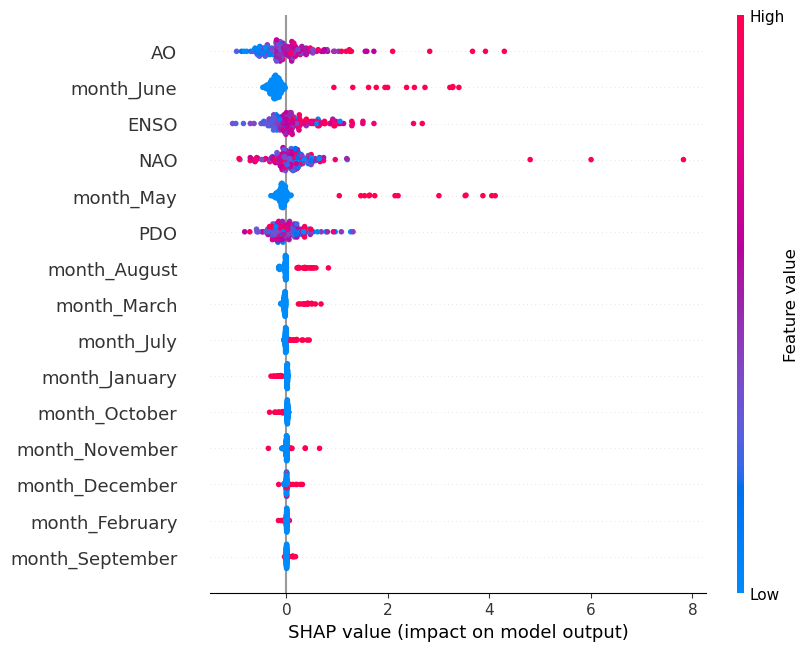

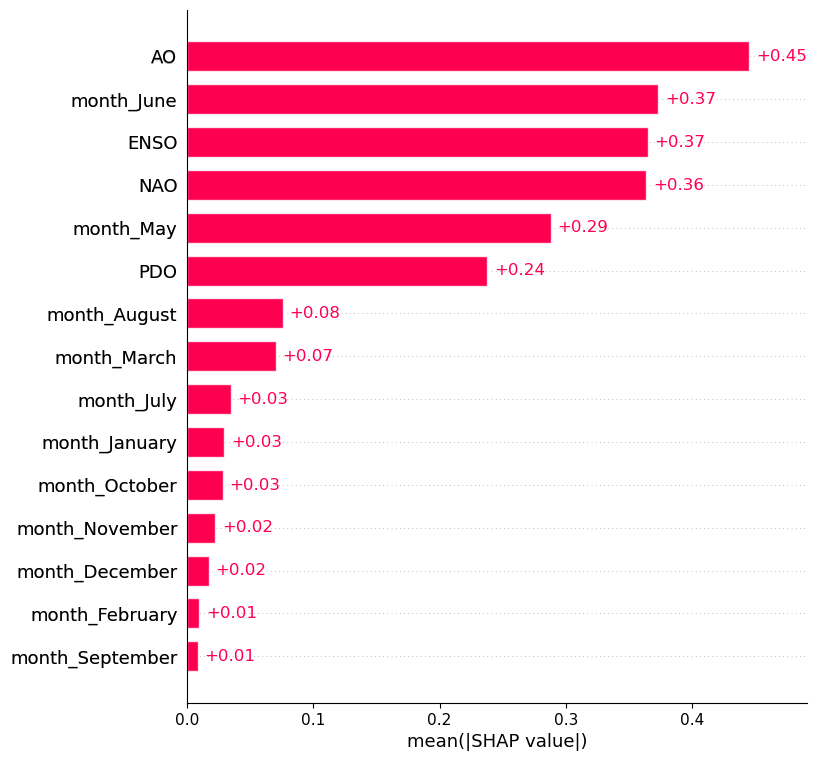

In [139]:
shap.plots.beeswarm(shap_values, max_display=16)
shap.plots.bar(shap_values, max_display=16)

(7) Create a SHAP Feature Dependence for the ENSO index.

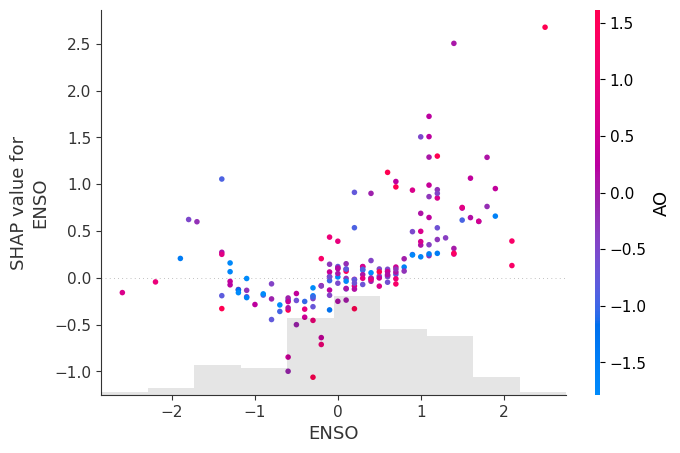

In [136]:
# ENSO dependence colored by strongest interaction automatically
shap.plots.scatter(shap_values[:, feature_names.index('ENSO')], color=shap_values)

(8) Any observations on the importance of the various features in your model from the XAI techniques you tried?

It is clear that the month an event occurs in is pretty important as evidenced by the permutation importances indicating that if the month it occurred in was taken out of the model, this would yield a pretty large decrease in the accuracy score. In some ways this make sense because the magnitude of low-frequency climate modes can vary depending on the month they occur in so use of low-frequency climate modes on their own may not be sufficient to get the results we want. In the SHAP analysis, it is clear that the months of May and June are very important to the model performance and the sum of SHAP values for all 12 months make them more important than the 4 climate modes, which is supported by the permutation importances figure that shows without the month column there is a severe decrease in model accuracy. 